In [1]:
!git clone https://github.com/aglie/seminar_disorder_2025.git

Cloning into 'seminar_disorder_2025'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 61 (delta 23), reused 24 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 2.76 MiB | 5.78 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [2]:
cd seminar_disorder_2025

/content/seminar_disorder_2025


In [3]:
!pip install ase
!pip install gemmi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.4 MB/s eta 0:00:00


# Imports

In [4]:
from mc_disordered_solid_fast import (
    initialize_lattice,
    calculate_energy,
    visualize_lattice,
    run_monte_carlo,
    convert_lattice_to_crystal_structure,
    calculate_average_diffuse_scattering,
    calculate_diffuse_scattering,
    centered_FFT,
    centered_iFFT
)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import for scattering calculations
from CalculateScattering import Grid, save_to_yell, CrystalStructure
from numpy.fft import fftshift, ifftn, fftn
from numpy import real, imag, angle, amax

Initial energy: 12.799999999999974


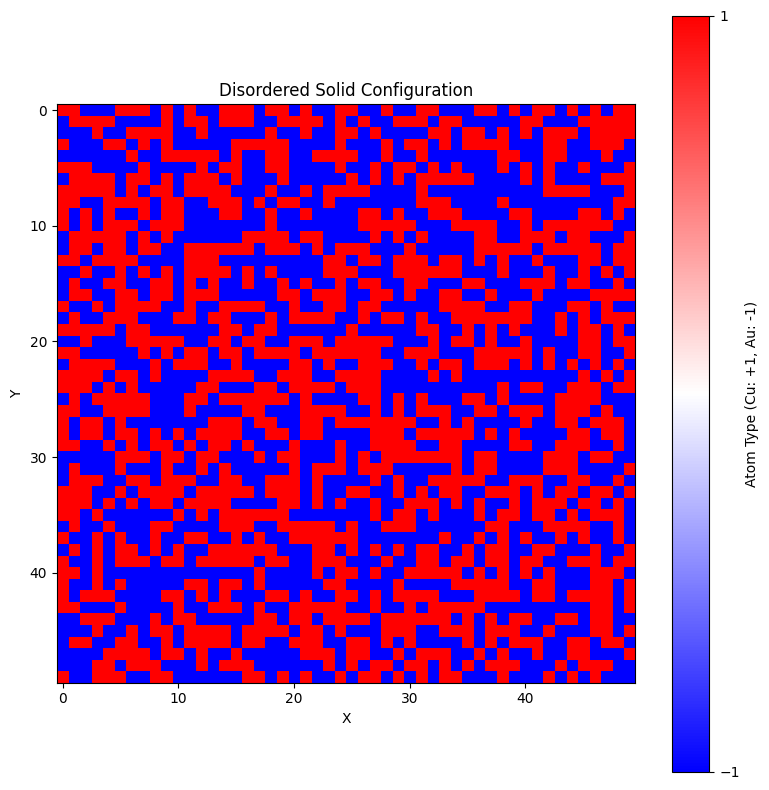

In [5]:
# Define parameters
lattice_size = (50, 50)

# Set J1 to -0.5 as in the original file
J1 = -0.2

# Define interactions (nearest neighbors by default)
interactions = [
    (1, 0, J1),   # Right neighbor
    (0, 1, J1),   # Bottom neighbor
    (-1, 0, J1),  # Left neighbor
    (0, -1, J1)   # Top neighbor
]

# Initialize lattice
initial_lattice = initialize_lattice(size=lattice_size)

# Calculate initial energy
initial_energy = calculate_energy(initial_lattice, interactions)
print(f"Initial energy: {initial_energy}")

# Visualize initial configuration
visualize_lattice(initial_lattice)

Running 1000 equilibration steps...
Equilibration complete.
Will save 10 configurations during production run
Running production: 10000 accepted moves...


100%|██████████| 10000/10000 [00:00<00:00, 256303.48it/s]

Move statistics:
  Accepted (energy lowering): 7190/19065 (37.71%)
  Accepted (energy raising): 3810/19065 (19.98%)
  Rejected: 8065/19065 (42.30%)
  Total acceptance ratio: 57.70%
Final energy: -199.19999999999297


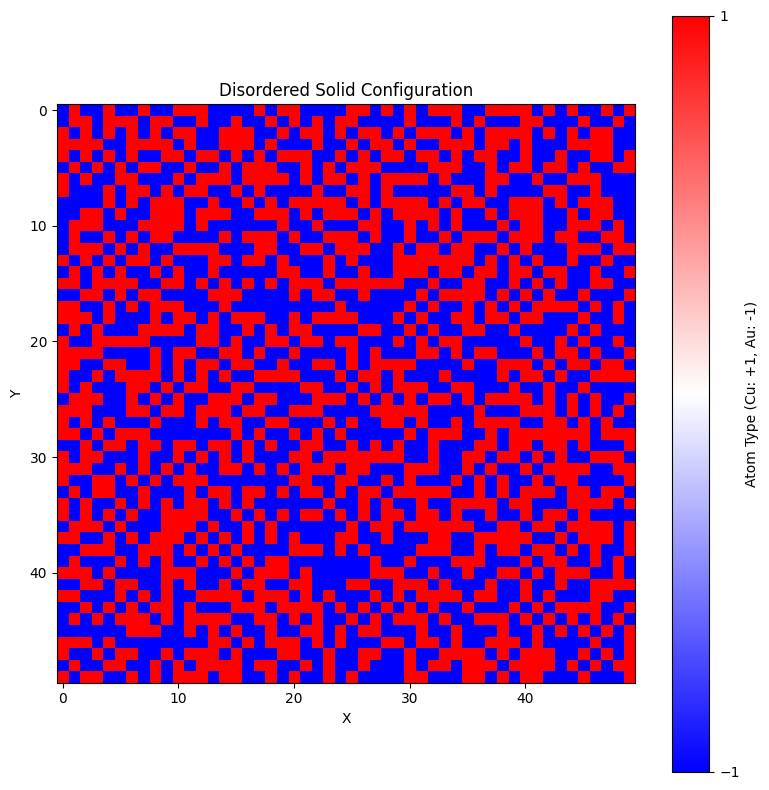

In [6]:
# Run Monte Carlo simulation
history, final_lattice, stats = run_monte_carlo(
    initial_lattice,
    interactions,
    total_accepted_moves=10000,        # Match original 1000 moves
    equilibration_steps=1000,         # Match original 1000 equilibration steps
    temperature=1.0,                  # Same temperature as original
    save_every=1000                    # Match original to save only one structure after equilibration
)

# Calculate final energy
final_energy = calculate_energy(final_lattice, interactions)
print(f"Final energy: {final_energy}")

# Visualize final configuration
visualize_lattice(final_lattice)

In [7]:
# Create a grid that will be reused
ll = 2  # lower limits, in reciprocal space coordinates
grid = Grid(
    lower_limits=[-ll, -ll, -1],  # q-vector lower limits
    step_sizes=[1/lattice_size[0], 1/lattice_size[1], 1],  # q-vector step sizes
    no_pixels=[ll*2*lattice_size[0], ll*2*lattice_size[1], 2]  # number of grid points
)

avg_intensities = calculate_average_diffuse_scattering (history, grid=grid)

Calculating average diffuse scattering from 11 configurations...


Processing configurations: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


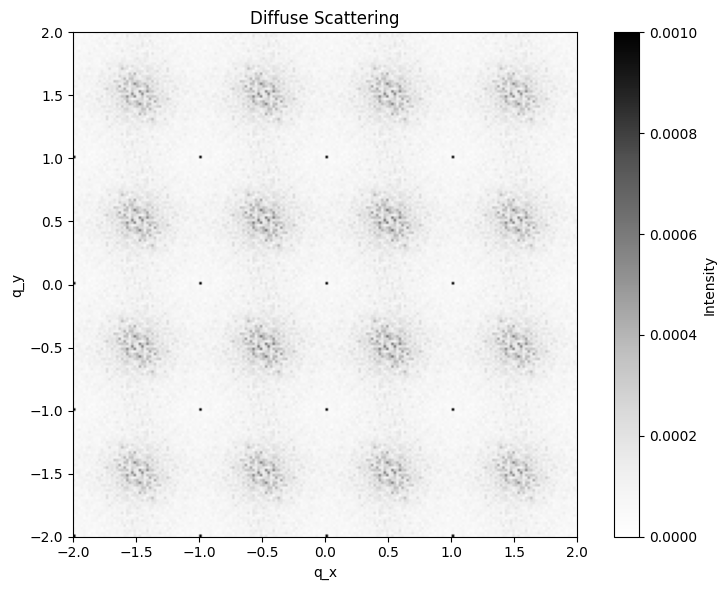

In [8]:
# Visualize diffuse scattering (full view)
cl = 0.001
plt.figure(figsize=(8, 6))
plt.imshow(avg_intensities,
           cmap='Greys',
           clim=[0,cl],
           origin='lower',
           extent=[grid.lower_limits[0], -grid.lower_limits[0], grid.lower_limits[1], -grid.lower_limits[1]])
plt.colorbar(label='Intensity')
plt.title("Diffuse Scattering")
plt.xlabel("q_x")
plt.ylabel("q_y")
plt.tight_layout()
plt.show()

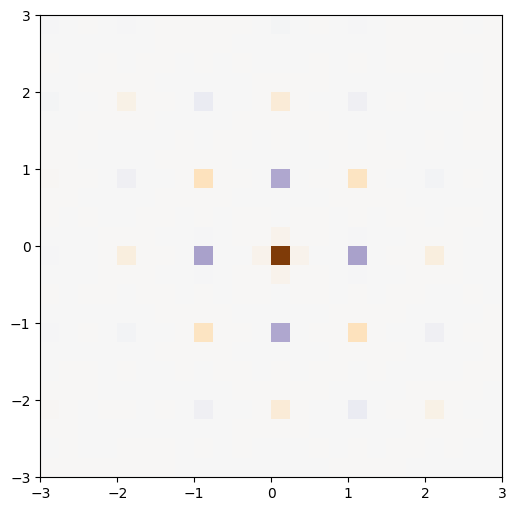

In [9]:
# Block 6: Calculate and visualize ∆PDF

# Please note that this time ∆PDF doesn't consist of individualgaussian shapes, rather it consists of coarse points
# this is because we calcualted much smaller portion of reciprocal space, which makes ∆PDF map coarser
punched_intensities = avg_intensities.copy()
punched_intensities[::lattice_size[0], ::lattice_size[1]] = 0
DeltaPDF = real(fftshift(fftn(fftshift(punched_intensities))))
clim = amax(DeltaPDF)/2
plt.figure(figsize=(8, 6))
plt.imshow(DeltaPDF,
           clim=[-clim,clim],
           extent=[-lattice_size[0]/2,lattice_size[0]/2, -lattice_size[1]/2, lattice_size[1]/2],
           cmap='PuOr_r')

sz = 3
plt.axis([-sz,sz,-sz,sz])
plt.show()

# Exercises

- Rearrange code, so it is convenient for you to solve the inverse problem. That is, to change starting parameters, and observe the resulting change in diffuse scattering.

- By changing the parameters try to reproduce the following diffuse scattering shapes:

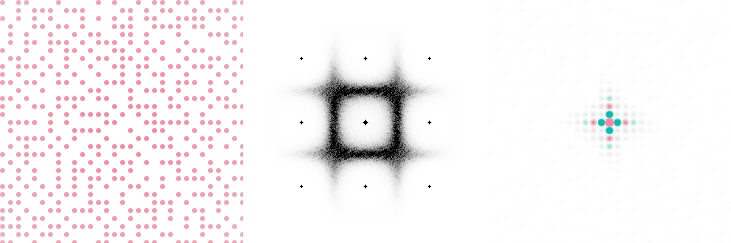

In [15]:
from IPython.display import Image, display

# For a single image
display(Image('disorder3.png'))

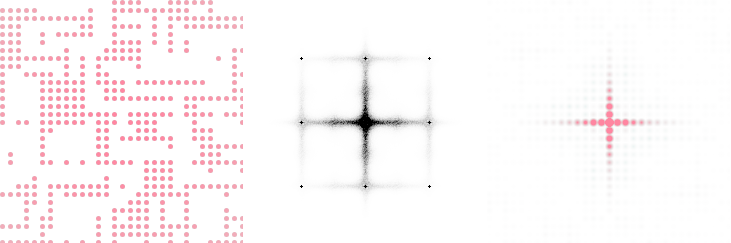

In [16]:
display(Image('disorder2.png'))

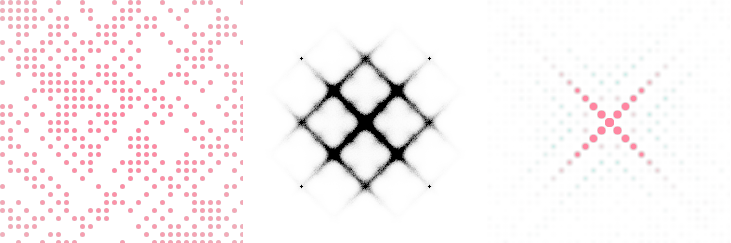

In [17]:
display(Image('disorder1.png'))